# Time-Frequency Analysis of mean LFP across channels

Let's take the mean across channels, then analyze the resulting LFP series.

To begin, do the usual bookkeeping and imports.

In [1]:
import numpy as np
import pandas as pd
import physutils as phys
import physutils.bootstrap as boot
import physutils.tf as tf
import matplotlib.pyplot as plt
import dbio

%matplotlib inline

Fetch some LFP data to play with:

In [2]:
import os
dbname = os.path.expanduser('data/bartc.hdf5')
dtup = 18, 1

In [3]:
lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

Now censor lfp, zscore to normalize, and average across channels:

In [4]:
lfpmz = lfp.censor().rzscore()
nanrows = np.any(np.isnan(lfpmz), axis=1)
lfpm = lfpmz.mean(axis=1)
lfpm[nanrows] = np.nan
lfpm = phys.LFPset(lfpm)

Get some example events from a behavioral task, the Balloon Analogue Risk Task (BART):

In [5]:
evt = dbio.fetch_all_such(dbname, 'events', *dtup)

Let's compare responses to two sets of events, voluntary stops and unexpected balloon pops:

In [6]:
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']
if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops

## We'll look at a window that begins 2.5 seconds before the event and ends 1.5 seconds after.

In [7]:
Tpre = -2.5
Tpost = 1.5
freqs = np.exp(np.linspace(np.log(2.5), np.log(50)))

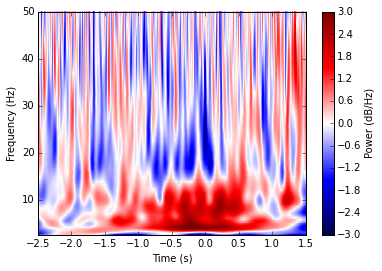

In [8]:
baseline_interval = (Tpre, Tpre + 0.75)
nf = phys.norm_by_mean(baseline_interval, method='division')
wav_normed, fig = lfpm.avg_time_frequency(0, stops_free, Tpre, Tpost, 
                                          method='wav', 
                                          normfun=nf, freqs=freqs, rasterized=True, 
                                          cmap='seismic', clim=(-3, 3)) 
plt.ylim(2.5, 50);

Let's try a contrast plot between two event types:

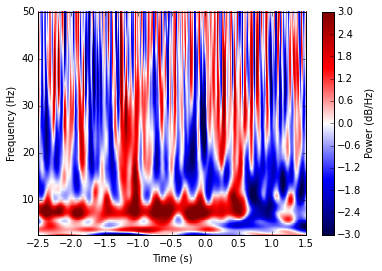

In [9]:
try:
    contr_tf, fig = lfpm.contrast_time_frequency(0, [stops_free, pops], Tpre, Tpost, method='wav',
                                             freqs=freqs, normfun=None, rasterized=True, cmap='seismic',
                                             clim=(-3, 3))
except:
    contr_tf, fig = lfpm.contrast_time_frequency(0, [stops_free, pops], Tpre, Tpost, method='wav',
                                             freqs=freqs, normfun=None, rasterized=True, cmap='seismic',
                                             clim=(-3, 3), complete_only=False)

In [10]:
def plot_diff_map(img, taxis, faxis):
    ax = plt.figure().add_subplot(111)
    extent = (taxis[0], taxis[-1], faxis[0], faxis[-1])
    im = tf.NonUniformImage(ax, interpolation=None, extent=extent)
    im.set_data(taxis, faxis, img.T)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.images.append(im)
    plt.colorbar(im)
    plt.ylim(0, 50)

In [11]:
series = lfpm.dataframe[0]
tffun = tf.continuous_wavelet
t0 = pd.DataFrame({'time':stops_free, 'label':0})
t1 = pd.DataFrame({'time':pops, 'label':1})
alltimes = pd.concat([t0, t1])
events = alltimes['time']
spectra, taxis, faxis = tf._per_event_time_frequency(series, tffun, events, Tpre, Tpost, 
                                                     normfun=None, complete_only=False)

In [12]:
labels = alltimes['label']
pos = boot.make_thresholded_diff(spectra, labels, hi=0.85)
neg = boot.make_thresholded_diff(spectra, labels, lo=0.15)

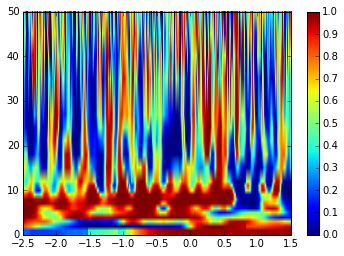

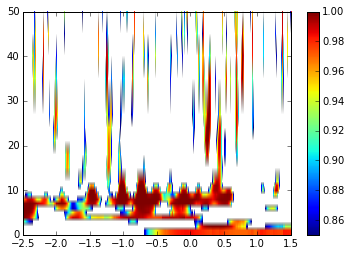

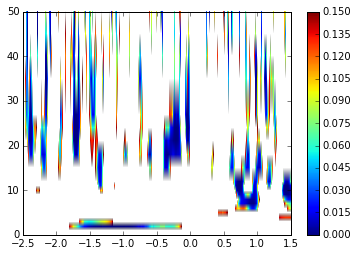

In [13]:
plot_diff_map(pos.data, taxis, faxis)
plot_diff_map(pos, taxis, faxis)
plot_diff_map(neg, taxis, faxis)

Now see whether any of the hot or cold spots is significant:

CPU times: user 33.7 s, sys: 48 ms, total: 33.7 s
Wall time: 33.8 s


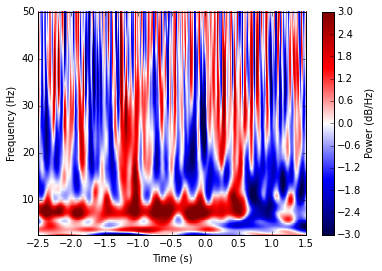

In [14]:
%%time
contr_tf, fig = lfpm.contrast_time_frequency(0, [stops, pops], Tpre, Tpost, freqs=freqs,
                                             method='wav', rasterized=True, cmap='seismic', clim=(-3, 3))

CPU times: user 1min 59s, sys: 4.26 s, total: 2min 3s
Wall time: 2min 3s


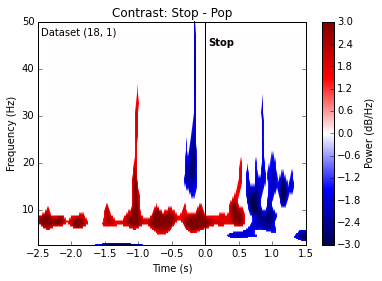

In [15]:
%%time
thresh = (0.10, 0.9)
mcontr, fig = lfpm.significant_time_frequency(0, [stops, pops], 
                                             Tpre, Tpost, thresh=thresh, 
                                             freqs=freqs,
                                             niter=100, method='wav', 
                                             doplot=True, rasterized=True, cmap='seismic', clim=(-3, 3))
# decorations
plt.axvline(x=0, color='k')
plt.text(0.05, 45, 'Stop', fontweight='bold')
plt.text(Tpre + 0.05, 47, "Dataset {}".format(str(dtup)))

plt.title('Contrast: Stop - Pop')

plt.tick_params(axis='x', which='both', top='off');